## Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import utils
from sklearn.preprocessing import StandardScaler
import scorecardpy as sc
import re

application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

# drop columns
data_full.drop(columns=['SELLER NAME', 'SERVICER NAME','DEFECT SETTLEMENT DATE', 'ZERO BALANCE EFFECTIVE DATE','DUE DATE OF LAST PAID INSTALLMENT (DDLPI)',
 'MI RECOVERIES', 'NET SALE PROCEEDS', 'NON MI RECOVERIES', 'TOTAL EXPENSES', 'LEGAL COSTS', 'MAINTENANCE AND PRESERVATION COSTS', 'TAXES AND INSURANCE', 'MISCELLANEOUS EXPENSES', 'ACTUAL LOSS CALCULATION',
 'POSTAL CODE', 'ZERO BALANCE REMOVAL UPB', 'PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER', 'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION',
 'FIRST PAYMENT DATE', 'MATURITY DATE'], inplace=True)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
#data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
#data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
#data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
#data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
#data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
#data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
#data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)

# change these columns to category 
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype('category')
data_full['ZERO BALANCE CODE'] = data_full['ZERO BALANCE CODE'].astype('category')
#data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'] = data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].astype('category')
data_full['PROPERTY VALUATION METHOD'] = data_full['PROPERTY VALUATION METHOD'].astype('category')


# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0).astype(int)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# turn into dummy variables
data_full = pd.get_dummies(data_full, columns=['MODIFICATION FLAG', 'ZERO BALANCE CODE', 
                                               'STEP MODIFICATION FLAG', 'PAYMENT DEFERRAL', 'DELINQUENCY DUE TO DISASTER', 
                                               'BORROWER ASSISTANCE STATUS CODE', 'FIRST TIME HOMEBUYER FLAG', 'OCCUPANCY STATUS', 
                                               'CHANNEL', 'PREPAYMENT PENALTY MORTGAGE (PPM) FLAG', 'AMORTIZATION TYPE', 'PROPERTY STATE', 
                                               'PROPERTY TYPE', 'LOAN PURPOSE', 'SUPER CONFORMING FLAG', 
                                               'PROGRAM INDICATOR', 'RELIEF REFINANCE INDICATOR', 'INTEREST ONLY INDICATOR (I/O INDICATOR)', 
                                               'MI CANCELLATION INDICATOR', 'PROPERTY VALUATION METHOD'], drop_first=True, dummy_na=True)

# drop credit score nulls only 40ish obs
data_full = data_full[~(data_full['CREDIT SCORE'].isnull())]

# drop DEFAULT column
data_full.drop(columns=['DEFAULT','DEFAULT CUM SUM'], inplace=True)

############# train test oot split ################

# make data
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12'])
y = data_full_train['DEFAULT_NEXT_12']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.5,  random_state=42)

# save the LOAN SEQUENCE NUMBER for later
X_train['LOAN SEQUENCE NUMBER'] = X_train.index
X_test['LOAN SEQUENCE NUMBER'] = X_test.index

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER','MONTHLY REPORTING PERIOD'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER', 'MONTHLY REPORTING PERIOD'], inplace=True)

# combine the train and test data
X_train['DEFAULT_NEXT_12'] = y_train
X_test['DEFAULT_NEXT_12'] = y_test

## Weight of Evidence

In [8]:
# get ordered and unordered variables
X_train_ordered, X_train_unordered = utils.split_dataframe_by_columns(X_train)
X_test_ordered, X_test_unordered = utils.split_dataframe_by_columns(X_test)
oot_ordered, oot_unordered = utils.split_dataframe_by_columns(data_full_oot)

# combine the train and test data
X_train_ordered['DEFAULT_NEXT_12'] = y_train.astype(int)
X_test_ordered['DEFAULT_NEXT_12'] = y_test



In [ ]:
breaks_list = {
    'NUMBER OF UNITS': [2.5, 3, 3.5],
    'CURRENT NON-INTEREST BEARING UPB': [2000,4000],
    'DELINQUENCY': [0.5],
    'LAST MONTH DELINQUENCY STATUS': [0.5, 1.5],
    'MONTHS IN DELINQUENCY PAST 12': [0.5, 1.5, 2.5, 4.5, 6.5]
    
}

bins = sc.woebin(X_train_ordered, y='DEFAULT_NEXT_12',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree',
                 breaks_list=breaks_list
                 )

breaks_adj = sc.woebin_adj(X_train_ordered, "DEFAULT_NEXT_12", bins, adj_all_var=True)

bins_adj = sc.woebin(
    X_train_ordered,
    y="DEFAULT_NEXT_12",
    breaks_list=breaks_adj 
)

train_woe = sc.woebin_ply(X_train_ordered, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_ordered, bins_adj) # Calculate WoE dataset (test)

# RUN THIS PICKLE CODE

In [ ]:
import pickle
# import pkl files
with open('model.pkl', 'rb') as f:
    model_dict = pickle.load(f)
bins_adj = model_dict['bins_adj']
model = model_dict['model']

train_woe = sc.woebin_ply(X_train_ordered, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_ordered, bins_adj) # Calculate WoE dataset (test)

[INFO] converting into woe values ...
Woe transformating on 310171 rows and 20 columns in 00:00:21
[INFO] converting into woe values ...
Woe transformating on 310650 rows and 20 columns in 00:00:23


In [11]:
######## standardize columns ########
# columns to be standardized
standardization_columns = ['CUMULATIVE MODIFICATION COST','DELINQUENT ACCRUED INTEREST', 'CURRENT MONTH MODIFICATION COST']

# create standard scaler on the train data
scaler = StandardScaler()
# fit the scaler on the train data
scaler.fit(X_train_unordered[standardization_columns])

# transform the train data
X_train_unordered[standardization_columns] = scaler.transform(X_train_unordered[standardization_columns])

# transform the test data
X_test_unordered[standardization_columns] = scaler.transform(X_test_unordered[standardization_columns])

# transform the oot data
oot_unordered[standardization_columns] = scaler.transform(oot_unordered[standardization_columns])


######### add unordered variables back to the train and test set #########
X_train_model = pd.concat([train_woe, X_train_unordered], axis=1)
X_test_model = pd.concat([test_woe, X_test_unordered], axis=1)

X_train_model = X_train_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_train_model = train_woe['DEFAULT_NEXT_12']

X_test_model = X_test_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_test_model = test_woe['DEFAULT_NEXT_12']


## Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score


# ADD CLASS WEIGHTS !!!!!!! ##########

model = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = 5,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.000001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=50, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = -1,      # Processes to use. Set to number of physical cores.
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.2), # The LASSO / Ridge ratios.
                                    )

model.fit(X_train_model, y_train_model)

y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)

y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 1, change: 1.00000000
Epoch 2, change: 0.18489468
Epoch 2, change: 0.10451473
Epoch 2, change: 0.20294046
Epoch 2, change: 0.16645957
Epoch 2, change: 0.09963645
Epoch 2, change: 0.14966894
Epoch 2, change: 0.14619437
Epoch 2, change: 0.18232411
Epoch 3, change: 0.04654393
Epoch 3, change: 0.07689769
Epoch 3, change: 0.08828950
Epoch 3, change: 0.11411016
Epoch 3, change: 0.07597041
Epoch 3, change: 0.05437936
Epoch 3, change: 0.07034575
Epoch 3, change: 0.08254524
Epoch 4, change: 0.03691763
Epoch 4, change: 0.05740431
Epoch 4, change: 0.06745655
Epoch 4, change: 0.03918532
Epoch 4, change: 0.06319200
Epoch 4, change: 0.04754314
Epoch 4, change: 0.04979569
Epoch 4, change: 0.03205938
Epoch 5, change: 0.01322408
Epoch 5, change: 0.01332065
Epoch 5, change: 0.02175214
Epoch 5, change: 0.0

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.6min finished


 AUC on test set: 0.8498


In [ ]:
y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)
print(f" AUC on train set: {auc_train:.4f}")

# get auc on test set
y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")


 AUC on train set: 0.8539


0.849485636212522


array([0.84123215, 0.85502222])

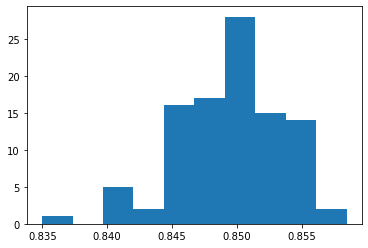

In [81]:
from sklearn.metrics import roc_auc_score

# make predictions
probs_test = model.predict_proba(X_test_model)[:, 1]

# Calculate bootstrap
test_preds = pd.DataFrame({'classes': y_test_model,
                           'probs': probs_test})
auc_boot = []

# Use 10,000 samples for IRL applications
for i in np.arange(100):
  sample = test_preds.sample(n=186260, replace=True)
  auc_boot.append(roc_auc_score(sample['classes'], sample['probs']))

plt.hist(auc_boot)

print(np.mean(auc_boot))

np.quantile(auc_boot, [0.025, 0.975])

## Scorecard

In [6]:
# coefficients in scorecard
def ab(points0=600, odds0=1/19, pdo=50):
    b = pdo/np.log(2)
    a = points0 + b*np.log(odds0) #log(odds0/(1+odds0))
    return {'a':a, 'b':b}

def scorecard(bins, model, xcolumns, points0=600, odds0=1/19, pdo=50, basepoints_eq0=False, digits=0):
    # coefficients
    aabb = ab(points0, odds0, pdo)
    a = aabb['a'] 
    b = aabb['b']
    # odds = pred/(1-pred); score = a - b*log(odds)
    
    # bins # if (is.list(bins)) rbindlist(bins)
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    xs = [re.sub('_woe$', '', i) for i in xcolumns]
    # coefficients
    coef_df = pd.Series(model.coef_[0], index=np.array(xs))\
      .loc[lambda x: x != 0]#.reset_index(drop=True)
    
    # scorecard
    len_x = len(coef_df)
    basepoints = a - b*model.intercept_[0]
    card = {}
    if basepoints_eq0:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':0}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i] + basepoints/len_x), ndigits=digits)\
              [["variable", "bin", "points"]]
    else:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':round(basepoints, ndigits=digits)}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i]), ndigits=digits)\
              [["variable", "bin", "points"]]
    return card

In [7]:
# scorecard
model_sc = scorecard(bins_adj, # bins from the WoE
                           model,  # Trained logistic regression
                           X_train_model.columns, # The column names in the trained LR
                           points0=750, # Base points
                           odds0=0.02, # Base odds bads:goods
                           pdo=50 # PDO
                           )

train_score = sc.scorecard_ply(X_train, model_sc,
                               print_step=0)

test_score = sc.scorecard_ply(X_test, model_sc,
                               print_step=0)

oot_score = sc.scorecard_ply(data_full_oot, model_sc,
                               print_step=0)



NameError: name 'X_train_model' is not defined

In [ ]:
# I want to pickle bins_adj and model objects into one dictionary
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump({'bins_adj': bins_adj, 'model': model, 'train_woe': train_woe, 'test_woe': test_woe}, f)



In [4]:
cutoffs = range(100, 700, 20)
profits = []

oot_with_score = data_full_oot.copy()
oot_with_score['score'] = oot_score['score'].astype(int)

for cut in cutoffs:
    approved = oot_with_score[oot_with_score['score'] >= cut]
    
    good = approved[approved['DEFAULT_NEXT_12'] == 0]
    bad = approved[approved['DEFAULT_NEXT_12'] == 1]
    
    # 收益来自好贷款
    income = 0.3 * good['CURRENT INTEREST RATE']/100 * good['CURRENT ACTUAL UPB']
    
    # 损失来自违约贷款
    loss = 0.4 * bad['CURRENT ACTUAL UPB']
    
    total_profit = income.sum() - loss.sum()
    profits.append(total_profit)

# Plotting the profit curve
plt.figure(figsize=(10, 6))
plt.plot(cutoffs, profits, marker='o')
plt.xlabel('Cutoff Score')
plt.ylabel('Total Profit')
plt.grid()
plt.xticks(cutoffs)
# vertical x labels
plt.xticks(rotation=90)
# make a vertical line at the maximum point
max_index = np.argmax(profits)
plt.axvline(x=cutoffs[max_index], color='r', linestyle='--', label='Max Profit Cutoff')
plt.legend()
plt.title('Profit Curve with Max Profit Cutoff')
plt.show()

NameError: name 'oot_score' is not defined

# Question 3

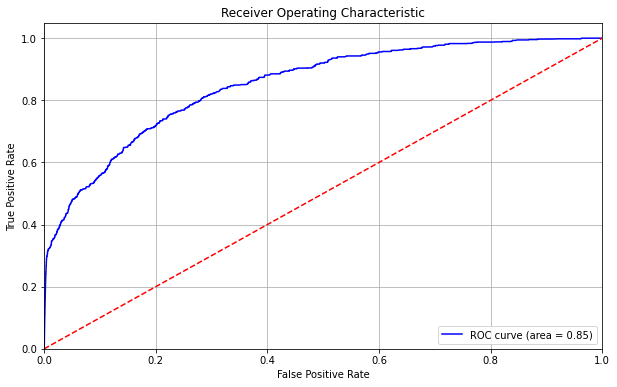

In [ ]:
# create auc curve for the logistic regression model 
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_model, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [109]:
y_test_pred

array([0.48123501, 0.48123501, 0.48123501, ..., 0.55251113, 0.63803351,
       0.4841564 ])

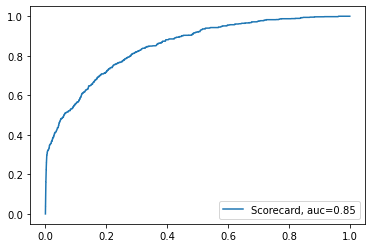

In [110]:
# Correct the infinite threshold
thresholds[0] = 1

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test_model,
                             y_score = y_test_pred),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [113]:
import pwlf
# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

# Calculate the best curve. Long!
nr_cuts = 10
res = piecewise_AUC.fitfast(nr_cuts, pop=2)

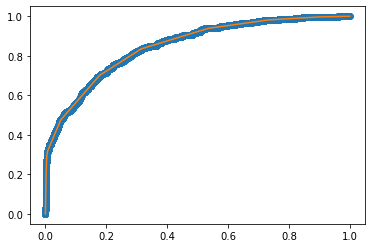

In [114]:
ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

# Apply cuts!
cuts = piecewise_AUC.fit_with_breaks(res)

# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [115]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
  # Get how far the fpr is from each ROC curve fpr point.
  temp = np.abs(np.round(ROC_curve.fpr, 2) - np.round(fpr, 2))

  # Get the index of the smallest value
  idx = np.argmin(temp)

  # Get the threshold associated with that point
  pbb_cuts[i] = ROC_curve.threshold[idx]
  i += 1

# Reverse to correctly sort
pbb_cuts = np.flip(pbb_cuts)
pbb_cuts

array([0.10775723, 0.17885518, 0.24761146, 0.32296055, 0.42041955,
       0.49918354, 0.63433211, 0.8192852 , 1.        , 1.        ,
       1.        ])

In [118]:
# Add 0 (and one) if not present. 1 is found, so we don't need to adjust it.
pbb_cuts = np.insert(pbb_cuts, 0, 0)

# Get unique values
pbb_cuts = np.unique(pbb_cuts)

# Display the result
pbb_cuts

pd_cut = pd.cut(y_test_pred, pbb_cuts)
pd_cut

[(0.42, 0.499], (0.42, 0.499], (0.42, 0.499], (0.42, 0.499], (0.42, 0.499], ..., (0.323, 0.42], (0.179, 0.248], (0.499, 0.634], (0.634, 0.819], (0.42, 0.499]]
Length: 310650
Categories (9, interval[float64, right]): [(0.0, 0.108] < (0.108, 0.179] < (0.179, 0.248] < (0.248, 0.323] ... (0.42, 0.499] < (0.499, 0.634] < (0.634, 0.819] < (0.819, 1.0]]

In [ ]:
import polars as pl
# Add the PDCut variable to our dataframe
loans = X_test.insert_column(-1,
    pl.Series('PD_Cut', pd.cut(y_test_pred.to_pandas(), pbb_cuts).astype(str).values)
)

loans = pd.DataFrame({'Default' : y_test_model, '})

# Create pivot table
PD_monthly = pd.pivot_table(loans.to_pandas(),
                            values = 'Default',
                            index = 'Portfolio',
                            columns = 'PD_Cut',
                            aggfunc = 'mean'
                            )

PD_monthly

: 

In [ ]:
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Add a new column for the true rate
PDs_Tab['Default Rate'] = PDs_Tab[True] / (PDs_Tab[True] + PDs_Tab[False])

# Display the updated table
PDs_Tab

DEFAULT_NEXT_12,False,True,True Rate,Default Rate
row_0,,,,
"(0.0, 0.108]",1849,0,0.000000,0.000000
"(0.108, 0.179]",33517,10,0.000298,0.000298
"(0.179, 0.248]",49159,55,0.001118,0.001118
"(0.248, 0.323]",61535,149,0.002416,0.002416
"(0.323, 0.42]",67581,373,0.005489,0.005489
"(0.42, 0.499]",39928,432,0.010704,0.010704
"(0.499, 0.634]",40012,783,0.019194,0.019194
"(0.634, 0.819]",12208,539,0.042284,0.042284
"(0.819, 1.0]",1525,995,0.394841,0.394841


In [131]:
# import df 
econ_factors = pd.read_csv('FRED-2024-07.csv')

In [132]:
econ_factors

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
2,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
3,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
4,5/1/1959,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5476,24.3911,23.1161,32.5567,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,2/1/2024,19307.749,15834.0,117.664,1.509152e+06,700519.00000,102.6045,100.8232,100.7468,101.6808,...,119.538,126.118,30.67,35.23,27.35,76.9,529015.93,921985.58,5112.3690,13.8808
782,3/1/2024,19340.458,15853.2,118.050,1.507101e+06,703738.00000,102.4062,100.5126,100.3951,101.1120,...,119.762,126.663,30.79,35.35,27.46,79.4,533250.65,922906.63,5208.4392,13.7658
783,4/1/2024,19331.853,15835.2,117.974,1.504491e+06,702681.00000,102.4329,100.6561,100.7962,101.8322,...,120.313,127.032,30.83,35.41,27.55,77.2,536813.09,926784.16,5160.8032,16.4023
784,5/1/2024,19406.215,15899.7,118.450,1.517365e+06,704483.00000,103.3282,101.3293,101.3132,102.4944,...,120.126,127.317,30.93,35.47,27.65,69.1,538996.20,929744.98,5171.8696,12.8609
